Задание 6: Обучить сиамскую сеть для верификации лиц на датасете LFW

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
#Загрузка библиотек
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
#Загрузка датасета
(ds_train, ds_test), ds_info = tfds.load('lfw',
                                         split=['train[:80%]', 'train[80%:]'], 
                                         as_supervised=True, 
                                         with_info=True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/13233 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/lfw/0.1.0.incompleteC7Y9S8/lfw-train.tfrecord*...:   0%|          | 0/13233 [0…

Dataset lfw downloaded and prepared to ~/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [4]:
len(ds_train), len(ds_test)

(10586, 2647)

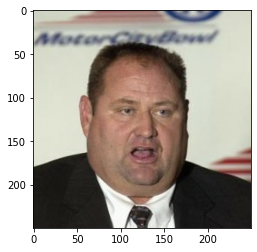

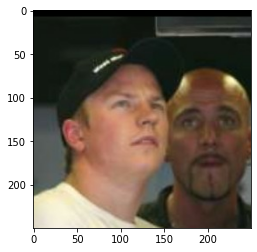

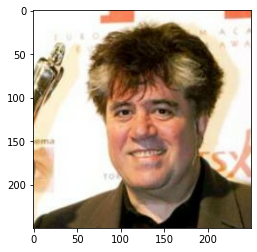

In [5]:
for example in ds_train.take(3):
    image, label = example[1], example[0]

    plt.imshow(image.numpy().astype(np.float32)/255)
    plt.show()

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
    'label': Text(shape=(), dtype=tf.string),
})

In [7]:
#Создание модели CNN
EMB_SIZE = 128

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [8]:
#Самописный Loss
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [9]:
#Пайплайн
INP_SIZE = 250
NUM_EPOCHS = 5
BATCH_SIZE = 32

def preprocessing(img):
    img = tf.cast(img, tf.float32)/255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE))

train_ds = ds_train.shuffle(buffer_size=len(ds_train))
train_ds = train_ds.map(lambda label, img: (preprocessing(img), label))
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = ds_test.shuffle(buffer_size=len(ds_test))
test_ds = test_ds.map(lambda label, img: (preprocessing(img), label))
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

In [10]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [11]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 85.54161071777344
[200] Loss: 0.456012487411499
[400] Loss: 0.21534201502799988
[600] Loss: 0.001090683857910335
[800] Loss: 0.29739314317703247
[1000] Loss: 0.022445129230618477
[1200] Loss: 0.0
[1400] Loss: 0.02763104811310768
[1600] Loss: 0.7072731256484985
CPU times: user 1min 48s, sys: 9.96 s, total: 1min 58s
Wall time: 3min 58s


In [19]:
person_1 = b'Erika_Harold'
person_2 = b'Pamela_Anderson'

In [24]:
test_img_list_A = [image for label, image in ds_test if label.numpy() == person_1] [:2]
test_img_list_B = [image for label, image in ds_test if label.numpy() == person_2][:1]
img_a1 = preprocessing(test_img_list_A[0])
img_a2 = preprocessing(test_img_list_A[1])
img_b1 = preprocessing(test_img_list_B[0])

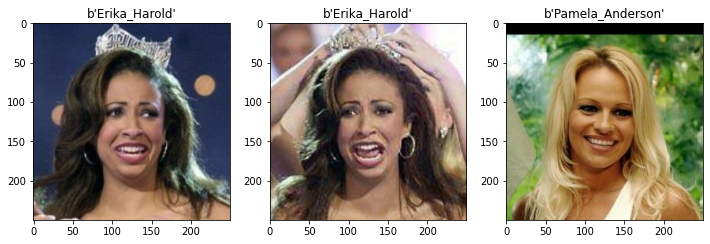

In [25]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
plt.title(person_1)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
plt.title(person_1)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1)
plt.title(person_2)
plt.show()

In [26]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0)) 

In [27]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print(f'{person_1}_1 <-> {person_1}_2: ', diff(emb1, emb2))
print(f'{person_1}_1 <-> {person_2}_1: ', diff(emb1, emb3))
print(f'{person_1}_2 <-> {person_2}_1: ', diff(emb2, emb3))

b'Erika_Harold'_1 <-> b'Erika_Harold'_2:  19.204826161681094
b'Erika_Harold'_1 <-> b'Pamela_Anderson'_1:  20.865237208795325
b'Erika_Harold'_2 <-> b'Pamela_Anderson'_1:  25.319187966774823
